In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [154]:
class Maze(object):
        
    staff_y = [0,60]
    staff_x = [0,10]
    bar_y = [50,60]
    bar_x = [-50,60]
    target_x = [-50,-30]
    target_y = [50,60]
    pickup_x = [40,60]
    pickup_y = [50,60]
    
    def __init__(self):
        pass
        
    def valid_x(self,x):
        if self.bar_x[0]<x<self.bar_x[1]:
            inBar_x = True
        else: inBar_x = False
        if self.staff_x[0]<x<self.staff_x[1]:
            inStaff_x = True
        else: inStaff_x = False
        return inBar_x, inStaff_x
        
    def valid_y(self,y):
        if self.bar_y[0]<y<self.bar_y[1]:
            inBar_y = True
        else: inBar_y = False
        if self.staff_y[0]<y<self.staff_y[1]:
            inStaff_y = True
        else: inStaff_y = False
        return inBar_y, inStaff_y
    
    def rough_location(self,position):
        inBar_x, inStaff_x = self.valid_x(position[0])
        inBar_y, inStaff_y = self.valid_y(position[1])
        inBar = inBar_x and inBar_y
        inStaff = inStaff_x and inStaff_y
        return inBar, inStaff
    
    def in_reward(self,position):
        if position[0]<self.target_x[1]:
            return True
        else:
            return False        
    
    def in_pickup(self,position):
        if position[0]>self.pickup_x[0]:
            return True
        else:
            return False
    
    
class Agent(object):
    
    reward = {
        'headache': -1,
        'cheese': 20
    }
    
    def __init__(self, pos = [5,0], eps = .99):
        self.position = np.array(pos)
        self.maze = Maze()
        self.inBar = False
        self.inStaff = True
        self.alpha = False
        self.rewarded = False
        self.placeFieldSize = 5
        
        self.placeCells = self.make_places()
        self.numberIn = len(self.placeCells.T)
        self.numberOut = 4 #given as value to start with
        self.directions = 2*np.pi*np.arange(0,self.numberOut)/self.numberOut
        
        self.currentActivation = np.zeros((2,self.numberIn))
        self.lastActivation = self.currentActivation.copy()

        self.currentQ = np.zeros(self.numberOut)
        self.lastQ = self.currentQ.copy()
        
        
        self.weights = np.random.random(size=(len(self.lastQ),len(self.lastActivation.flatten())))
        self.trace = np.zeros_like(self.weights)

        self.lastAction = None
        self.currentAction = None
        
        self.eps = eps
        self.gamma = 0.95
        self.eta = 0.9
        self.decayRate = 0.5
        self.rt = 0
        
        self.route = []
        self.route.append(self.position)

        self.epoch_num = 0
        
    def reset(self):
        self.position = np.array([5,0])
        self.inBar = False
        self.inStaff = True
        self.alpha = False
        self.rewarded = False
        
    def make_places(self, offset = 2.5, seperation = 5):
        """
        Create the centers of the place cell activity.
        
        Args:
        offset - how far from the edge the first place cell should
        seperation - the distance between adjacent centers measured in one dimension
        
        For both the staff and the bar of the T maze meshgrids are created
        (in such a way as to not overlap!) which are flattened and then h- and vstacked
        to create a 2 x #(place cells) array that stores the centers
        The offset is only taken into account on one side.
        """
        x = np.arange(offset,self.maze.bar_x[-1],seperation)
        y = np.arange(offset,self.maze.bar_y[-1],seperation)
        XX, YY = np.meshgrid(x,y)
        bargrid = np.vstack((XX.flatten(),YY.flatten()))
        x = np.arange(offset,self.maze.staff_x[-1],seperation)
        y = np.arange(offset,self.maze.bar_y[0],seperation)
        XX, YY = np.meshgrid(x,y)
        staffgrid = np.vstack((XX.flatten(),YY.flatten()))
        cells = np.hstack((bargrid,staffgrid))
        return cells
    
    def input_layer(self):
        """Compute the activation of the input layer for a given position and state and update the variable
        """
        activation = np.zeros(np.shape(self.lastActivation))
        for i in range(len(self.lastActivation)):
            kronecker = bool(i)==self.alpha
            activation[i] = kronecker*np.exp(-np.sum((self.placeCells.T-self.position)**2,axis=1)/(2*self.placeFieldSize**2))
        self.lastActivation = activation
        
    def output_layer(self):
        self.lastQ = np.dot(self.weights,self.lastActivation.flatten())
    
    def choose_action(self):
        """
        Eps-greedy action policy
        """
        if np.random.random() < self.eps:
            self.currentAction = np.random.randint(self.numberOut)
        else:
            self.currentAction = self.lastQ.argmax()
        
    def valid_move(self,new_position):
        """
        Checks if a move is valid, and changes state variables accordingly
        """
        inBar, inStaff = self.maze.rough_location(new_position)
        if self.inBar==inBar or self.inStaff==inStaff:
            if inBar or inStaff:
                self.inBar = inBar
                self.inStaff = inStaff
                return True
            else: return False
        else: return False
    
    def check_task(self):     
        if not self.alpha:
            self.alpha = self.maze.in_pickup(self.position)
        else:
            if self.maze.in_reward(self.position):
                self.rewarded = True
        return self.rewarded
    
    def move(self):
        direction = self.directions[self.currentAction]
        distance = np.random.normal(loc=3,scale=1.5)
        move = np.array([np.cos(direction)*distance,np.sin(direction)*distance])
        new_position = self.position + move
        valid = self.valid_move(new_position)
        if valid:
            self.position = new_position
        return valid    

    def trace_update(self):
        self.trace *= self.gamma * self.decayRate 
        self.trace[self.currentAction, :] += self.currentActivation.flatten()
        
        
    def Q_update(self):
        delta_t = (self.rt + (self.gamma * self.currentQ[self.currentAction] - self.lastQ[self.lastAction]))
        delta_w = self.eta * delta_t.T * self.trace[self.currentAction, :]
        self.weights += delta_w

    def step(self, verbose = False):
        self.input_layer()
        self.output_layer()    
        self.choose_action()
#         self.currentActivation = self.lastActivation ?????/
        
        valid = self.move()
        self.rt += self.reward['headache'] * int(not valid)
        rewarded = self.check_task()        
        self.rt += self.reward['cheese'] * int(rewarded)
    
        if verbose:
            print('valid: ', valid)
            print('rewarded:' , rewarded)
            print('r_t: ', self.rt)

        self.trace_update()
        self.Q_update()
        
        self.lastActivation = self.currentActivation
        self.lastQ = self.currentQ
        self.lastAction = self.currentAction
        self.rt = 0
        self.route.append(self.position)
        
        
    def trial(self, eta_decay = 0.1, plot = False):
        self.reset()
        k=0
        alpha_ = False
        while not mouse.rewarded:
            self.step()
            if self.alpha and not alpha_:
                pickupsteps = k
                print(('found pickup after %.d steps'%(k)))
                alpha_ = True
            k+=1  
            
        print()
        print(('made it to target area after %.d steps'%(k)))
        
        self.eps -= self.epoch_num * eta_decay

        if plot:     
            route = np.asarray(self.route)
            plt.scatter(route[:,0], route[:,1],marker='.',linewidths=0)
            plt.gca().set_aspect('equal')
            plt.show()


In [155]:
mouse = Agent(eps = 0.5)

found pickup after 647 steps

made it to target area after 2420 steps


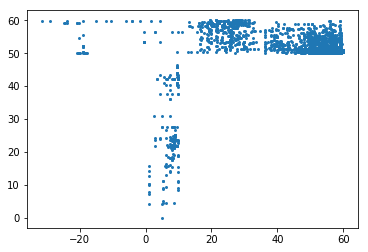

In [156]:
mouse.trial(plot = True)

In [85]:
N = 100000
for i in range(N):
    mouse.step(verbose = 0)


In [81]:
r = np.array(mouse.route)


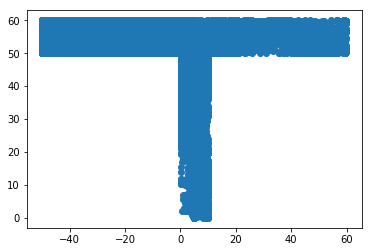

In [82]:
plt.scatter(r[:,0], r[:,1])
plt.show()

In [222]:
mouse.trace, mouse.inputLayer

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[  5.86101871e-01,   8.92311360e-01,   4.99764328e-01,
           1.02972108e-01,   7.80511800e-03,   2.17643078e-04,
           2.23262490e-06,   8.42543219e-09,   1.16969903e-11,
           5.97395006e-15,   1.12241785e-18,   7.75805868e-23,
           5.69161993e-01,   8.66521226e-01,   4.85319831e-01,
           9.99959449e-02,   7.57952966e-03,   2.11352624e-04,
           2.16809620e-06,   8.18191515e-09,   1.13589166e-11,
           5.80128727e-15,   1.08997704e-18,   7.53383048e-23,
           2.03331279e-01,   3.09561903e-01,   1.73378939e-01,
           3.57232276e-02,   2.70776243e-03,   7.55050406e-05,
           7.74545349e-07,   2.92296270e-09,   4.05793620e-12,
           2.07249110e-15,   3.89390768e-19,   2.69143655e-23,
           2.67225570e-02,   4.06837828e-02,   2.27861084e-02,

In [484]:
Q = mouse.Q
at = mouse.last_action
at1 = mouse.current_action
pos = mouse.position
